# Preference Learning - Part II
## 1. Principle Component Analysis (PCA)
## 2. Gaussian Mixture Models (GMM)
## 3. Groups' Price Responsiveness

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

## 1. Principle Component Analysis
We first focus on the non-event data. For each hour, 

(1) the first approach is we do principle component analysis and get several explanable top PCs and then use the top PCs to do K-mean clustering to find out groups; 

(2) the second approach is forget about PCA, and start by drawing histogram of distribution on a temp, consumption, occurence 3D space, and using GMM to fit the data and find out the classes.

In [3]:
# Import all preprocessed data necessary for the analysis
df_tou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_tou2013_1h.csv")
df_Ntou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_Ntou2013_1h.csv")
df_wea1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\weather\\LondonWeather2013_interpolated.csv")
df_tariff_1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\df_tariff_1h.csv")

In [2]:
import os
os.getcwd()

'/Users/Rockwell/Documents/GitHub/Demand-Response'

In [3]:
# for ios system, import all data necessary for the analysis
df_tou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_tou2013_1h.csv')
df_Ntou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_Ntou2013_1h.csv')
df_wea1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/LondonWeather2013_interpolated.csv')
df_tariff_1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/df_tariff_1h.csv')

In [6]:
# first, create a list of days that belongs to event days
event_days = set()
event_series = df_tariff_1h[df_tariff_1h.Event_tags.notnull()].GMT
for i in event_series:
    event_days.add(datetime.strptime(i[:10], "%Y-%m-%d" ).date()) # add all event dates to the set
df_help = pd.DataFrame(pd.to_datetime(df_tariff_1h.GMT).dt.date) #str to datatime and extract date then make it to dataframe
# df_help[df_help['GMT'].isin(event_days)] #this shows the event days
# we can use ~df_help['GMT'].isin(event_days) to generate any non-flexible period items

# create TOU and non-TOU demand data in non-flexible hours
df_wea1h_nf = df_wea1h[~df_help['GMT'].isin(event_days)]
df_Ntou1h_nf = df_Ntou1h[~df_help['GMT'].isin(event_days)]
df_tou1h_nf = df_tou1h[~df_help['GMT'].isin(event_days)]

In [78]:
# seperate the above data set based on the seasonal effect
# i.e., months of 11, 12, 1, 2, 3 are in a group - cold season
# months of 4, 5, 6, 7, 8, 9, 10 are in another group - warm season
cold_season = [11, 12, 1, 2, 3]
warm_season = [4, 5, 6, 7, 8, 9, 10]
df_help_season = pd.DataFrame(pd.to_datetime(df_wea1h_nf.GMT).dt.month)
df_wea1h_nf_cold = df_wea1h_nf[df_help_season['GMT'].isin(cold_season)]
df_wea1h_nf_warm = df_wea1h_nf[df_help_season['GMT'].isin(warm_season)]
df_Ntou1h_nf_cold = df_Ntou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_Ntou1h_nf_warm = df_Ntou1h_nf[df_help_season['GMT'].isin(warm_season)]
df_tou1h_nf_cold = df_tou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_tou1h_nf_warm = df_tou1h_nf[df_help_season['GMT'].isin(warm_season)]

(1) In PCA, we don't consider normalization since all the consumptions have the same unit, we care about the absolute change rather than relative change since DR targets the customer who has largest potential shiftable load instead of largest price-responsiveness rate. Also we have seperate data by hours, so the temp-consumption relationship at different hours has been treated seprately and equally, so the time effect won't be a concern to let us normalize the data.

In [79]:
df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('09:00:00')].transpose()

,9,33,57,105,129,201,273,321,345,417,...,8409,8433,8505,8529,8553,8577,8601,8649,8673,8745
GMT,2013-01-01 09:00:00,2013-01-02 09:00:00,2013-01-03 09:00:00,2013-01-05 09:00:00,2013-01-06 09:00:00,2013-01-09 09:00:00,2013-01-12 09:00:00,2013-01-14 09:00:00,2013-01-15 09:00:00,2013-01-18 09:00:00,...,2013-12-17 09:00:00,2013-12-18 09:00:00,2013-12-21 09:00:00,2013-12-22 09:00:00,2013-12-23 09:00:00,2013-12-24 09:00:00,2013-12-25 09:00:00,2013-12-27 09:00:00,2013-12-28 09:00:00,2013-12-31 09:00:00
D0000,0.178,0.092,0.484,0.095,0.087,0.114,0.064,0.069,0.169,0.101,...,0.354,0.094,0.193,0.076,0.1,0.094,0.347,0.103,0.12,0.107
D0001,0.463,0.469,0.604,0.43,0.441,0.416,0.465,0.551,0.335,0.383,...,0.436,0.375,0.504,0.732,0.344,0.466,0.495,0.474,0.448,0.5
D0002,0.482,0.495,0.463,0.42,0.415,1.417,1.122,1.105,0.383,1.757,...,1.068,1.315,0.545,0.944,1.551,1.827,1.941,1.058,0.711,0.278
D0003,0.153,0.152,0.451,0.155,0.329,0.154,0.147,0.147,0.145,0.142,...,0.114,0.28,0.286,0.613,0.29,0.099,0.508,0.099,0.099,0.101
D0004,0.231,0.309,0.342,0.759,0.278,0.054,0.282,0.146,0.054,0.425,...,0.107,0.252,0.992,0.867,0.061,0.508,0.388,0.418,0.257,0.335
D0005,0.136,0.367,0.267,0.294,0.261,0.288,0.285,0.274,0.281,0.432,...,0.335,0.327,0.292,0.291,0.309,0.435,0.259,0.447,0.376,0.299
D0006,0.096,0.244,0.701,0.065,0.096,0.683,0.237,1.004,0.214,0.406,...,0.999,0.466,0.096,0.392,0.25,0.313,0.933,0.197,0.183,0.474
D0007,0.177,0.191,0.425,0.324,0.275,0.32,0.299,0.206,0.244,0.321,...,0.75,0.229,0.346,0.434,0.381,0.371,0.721,0.379,0.277,0.267
D0008,0.168,0.33,0.25,0.121,0.148,0.225,0.229,0.145,0.292,0.425,...,0.296,0.427,0.154,0.279,0.221,0.185,0.245,0.264,0.233,0.636


In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Test with 9:00 am TOU data
x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('09:00:00')]
x.set_index('GMT', inplace = True)
x = x.transpose().dropna() # data for the specific hour, and filtering out null value
x = x.values
x = StandardScaler().fit_transform(x)
pca = PCA()# keep all columns to cover 100% variance
principleComponents = pca.fit_transform(x)
principleDf = pd.DataFrame(data = principleComponents)
principleDf

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,-4.534874,0.453149,-0.791187,0.190559,-0.019240,-0.216637,0.002832,0.033447,-0.200984,-0.116277,...,0.047344,-0.035443,0.137083,0.474916,0.034152,0.107072,0.159034,-0.031716,0.123355,-0.153489
1,-2.259145,-0.894439,0.065706,-1.158057,-0.169163,-0.384709,0.269293,0.295374,0.321222,0.080441,...,-0.084316,-0.186530,-0.130358,-0.034712,-0.006197,-0.119398,0.343977,-0.289739,-0.119886,-0.058059
2,6.623904,0.566495,2.227523,0.283639,1.263913,0.823391,-1.208211,1.297698,-0.745383,-0.250109,...,0.207286,-0.313115,0.225530,-0.280195,-0.302490,-0.344385,-1.264445,0.194463,-0.853237,0.018002
3,-2.740304,1.903443,0.820230,0.305847,0.466140,-0.485148,-0.582654,0.260836,-0.090145,-0.733082,...,0.106626,-0.212085,-0.366768,-0.382301,0.311492,-0.248992,0.155875,-0.785471,-0.353172,0.262261
4,-3.662682,-0.357209,1.408946,-0.311664,0.480621,-0.457705,-0.179151,0.287924,0.007132,0.492172,...,0.301034,-0.272460,-0.140303,-0.287819,-0.519964,0.113296,0.174142,0.074868,0.221217,0.093631
5,-2.355763,-0.460153,-0.311662,0.083363,0.184648,-0.127965,0.004612,-0.082631,0.190776,-0.060942,...,-0.029751,-0.047663,0.039299,-0.061316,-0.162310,-0.082337,-0.120726,-0.014306,0.055225,0.051374
6,-1.970082,0.457461,-1.200723,-0.310279,0.513020,-0.830899,0.089446,0.092306,-0.365178,-0.462662,...,-0.015333,-0.566890,0.363407,0.492484,-0.334805,0.010506,-0.002345,0.261855,-0.248988,-0.244783
7,-0.681808,0.273903,-0.735341,-0.149064,0.061141,-0.226158,-0.949310,-0.030437,-0.046488,-0.241626,...,-0.056229,0.218000,0.308144,0.170152,-0.910241,-0.669275,0.174031,0.458074,-0.976144,0.033914
8,-3.266754,0.000133,-0.386045,-0.399162,0.111960,0.136354,-0.249222,-0.018619,-0.546985,0.047331,...,-0.105117,0.140664,-0.167046,0.114288,0.087331,-0.014503,0.108202,0.426303,0.206896,0.185994
9,0.400567,0.209370,1.729419,2.746633,-0.107041,0.326880,-2.408428,0.175536,1.585223,1.549523,...,-0.598657,-0.972921,-0.054188,0.903217,-0.264640,0.238563,-0.514249,0.095157,0.127006,0.482957


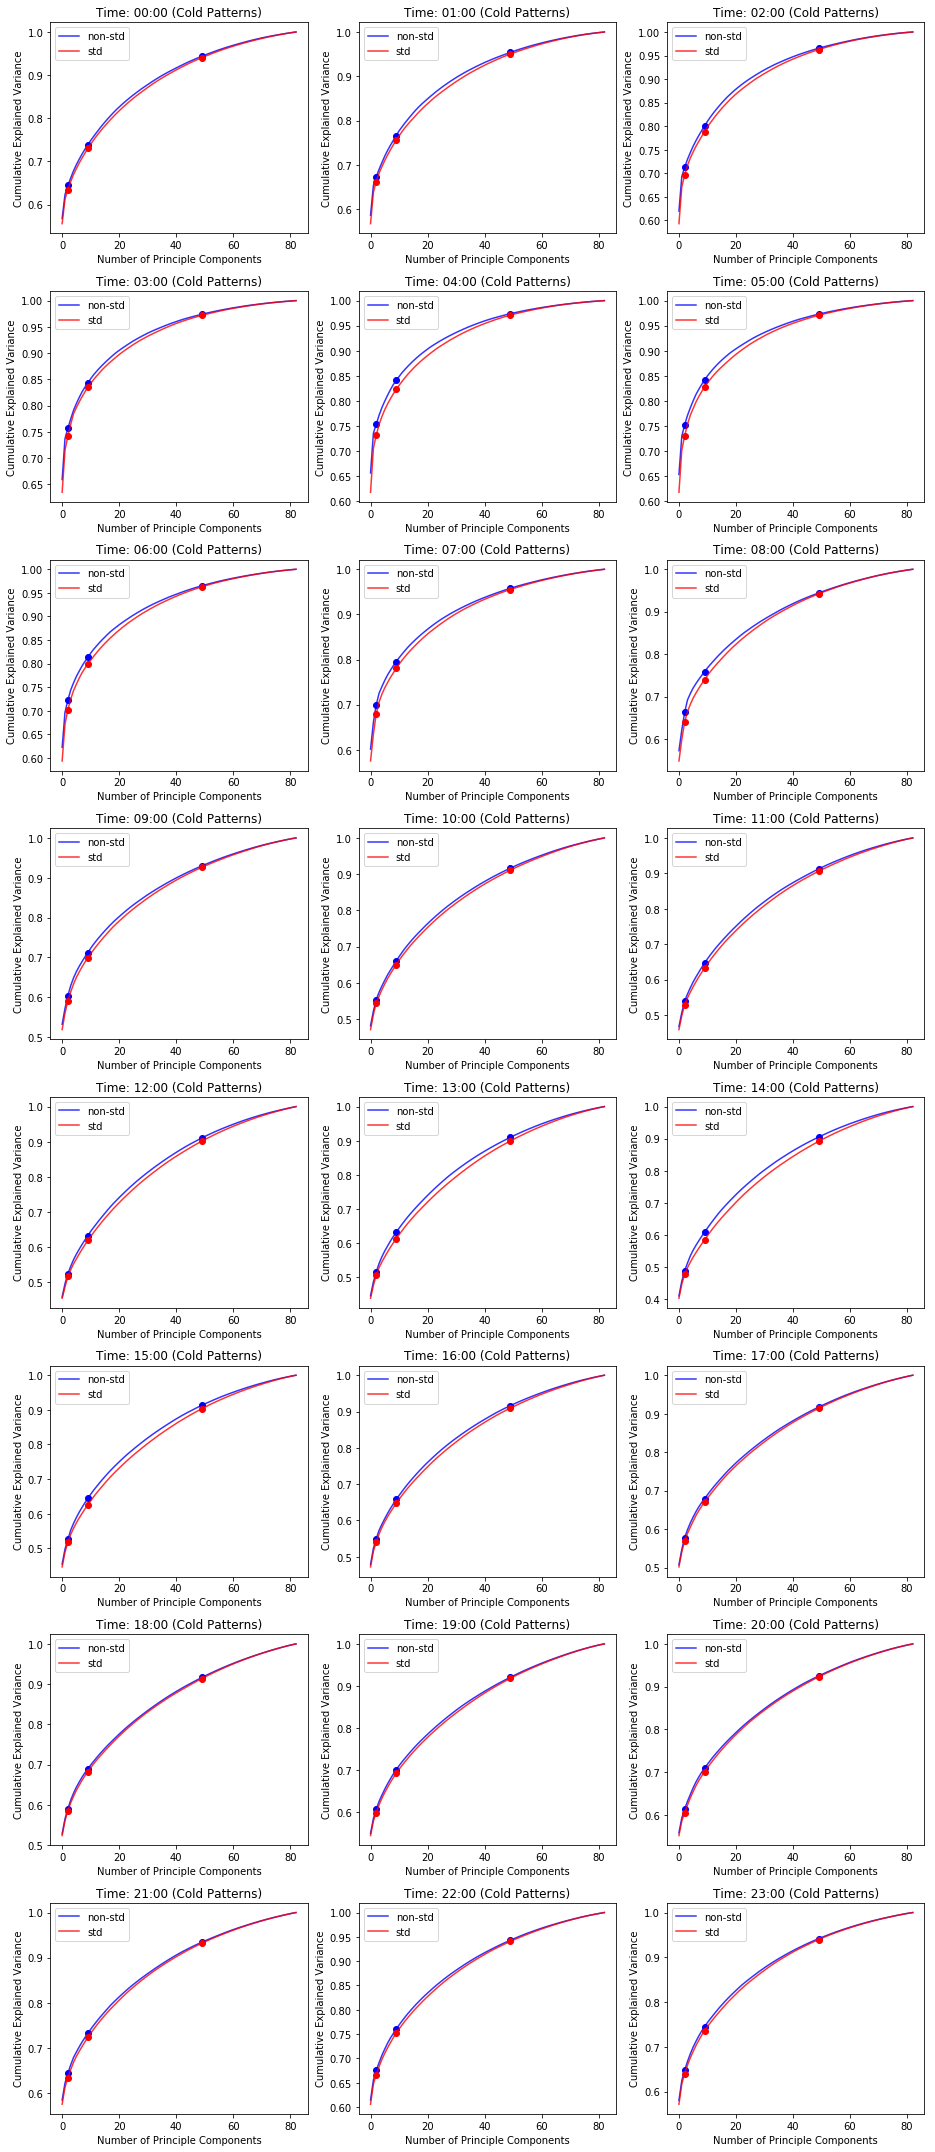

In [210]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.plot(np.cumsum(pca_nstd.explained_variance_ratio_), c = 'blue', label = 'non-std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca_nstd.explained_variance_ratio_)[2], np.cumsum(pca_nstd.explained_variance_ratio_)[9], np.cumsum(pca_nstd.explained_variance_ratio_)[49]], 'bo')
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.plot(np.cumsum(pca.explained_variance_ratio_), c = 'red', label = 'std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca.explained_variance_ratio_)[2], np.cumsum(pca.explained_variance_ratio_)[9], np.cumsum(pca.explained_variance_ratio_)[49]], 'ro')
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Number of Principle Components')
        ax.set_ylabel('Cumulative Explained Variance')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.plot(np.cumsum(pca_nstd.explained_variance_ratio_), c = 'blue', label = 'non-std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca_nstd.explained_variance_ratio_)[2], np.cumsum(pca_nstd.explained_variance_ratio_)[9], np.cumsum(pca_nstd.explained_variance_ratio_)[49]], 'bo')
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.plot(np.cumsum(pca.explained_variance_ratio_), c = 'red', label = 'std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca.explained_variance_ratio_)[2], np.cumsum(pca.explained_variance_ratio_)[9], np.cumsum(pca.explained_variance_ratio_)[49]], 'ro')
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Number of Principle Components')
        ax.set_ylabel('Cumulative Explained Variance')
plt.tight_layout()

The above pictures show that using the first 3 PCs can always explain from 48% to 72% amount of variance. 

Next we will give the meaning of the first 3 PCs:

PC1 & PC2: temperature related (no matter of standarization, PC1 and PC2 are somehow correlated)

PC3: related to days of week, since the coeffients of Friday and Saturday are skewied to positive area, if there's not correlation, it should always be equally distributed around 0

Using the 3 components to do k-mean clustering and we can get several groups

Coloring them in a 3D space (or if the first two PCs leads to some confustion, maybe do 2D with 3 differnt projections)

Then we could try to color them in a 2D slice surphase (temp vs day of week, temp )


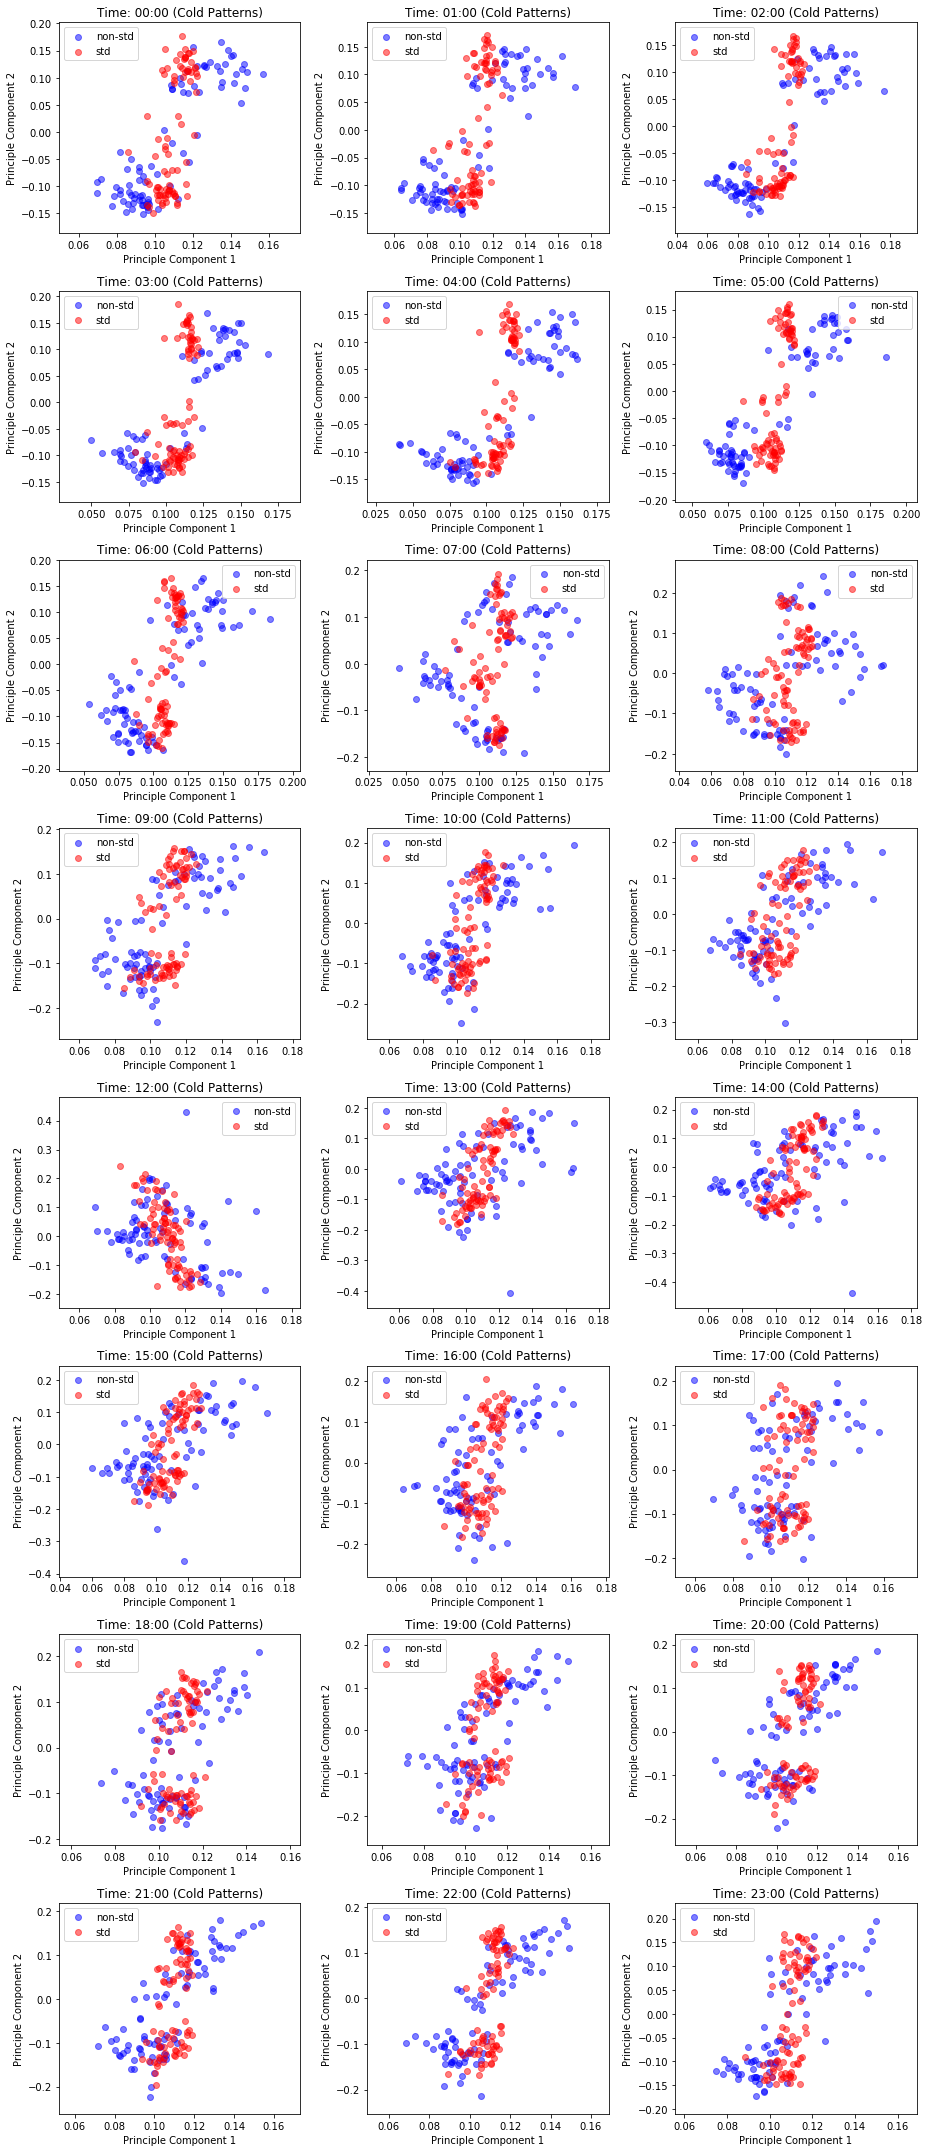

In [211]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[0], pca_nstd.components_[1], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(pca.components_[0], pca.components_[1], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[0], pca_nstd.components_[1], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(pca.components_[0], pca.components_[1], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
plt.tight_layout()

Component 1 and Component 3 relationship is shown below

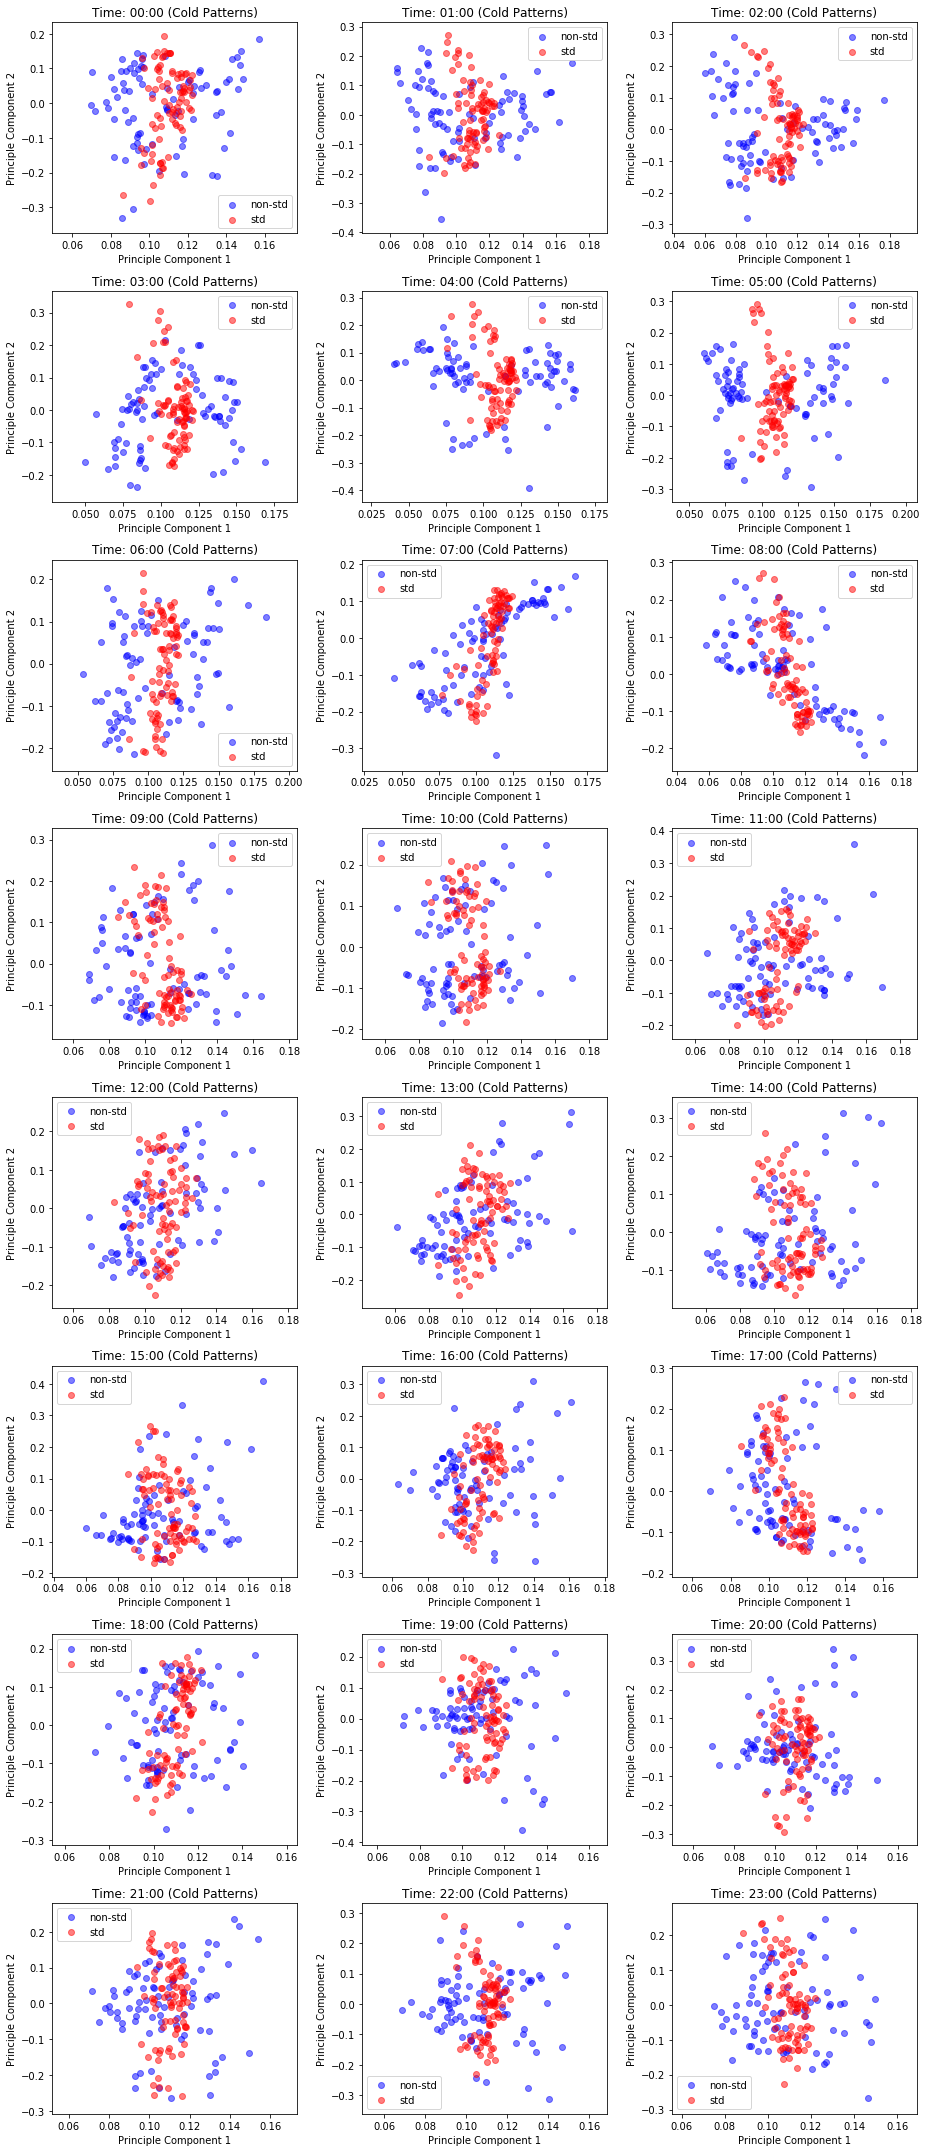

In [212]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[0], pca_nstd.components_[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(pca.components_[0], pca.components_[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[0], pca_nstd.components_[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(pca.components_[0], pca.components_[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
plt.tight_layout()

Component 2 and Component 3 relationship is shown below

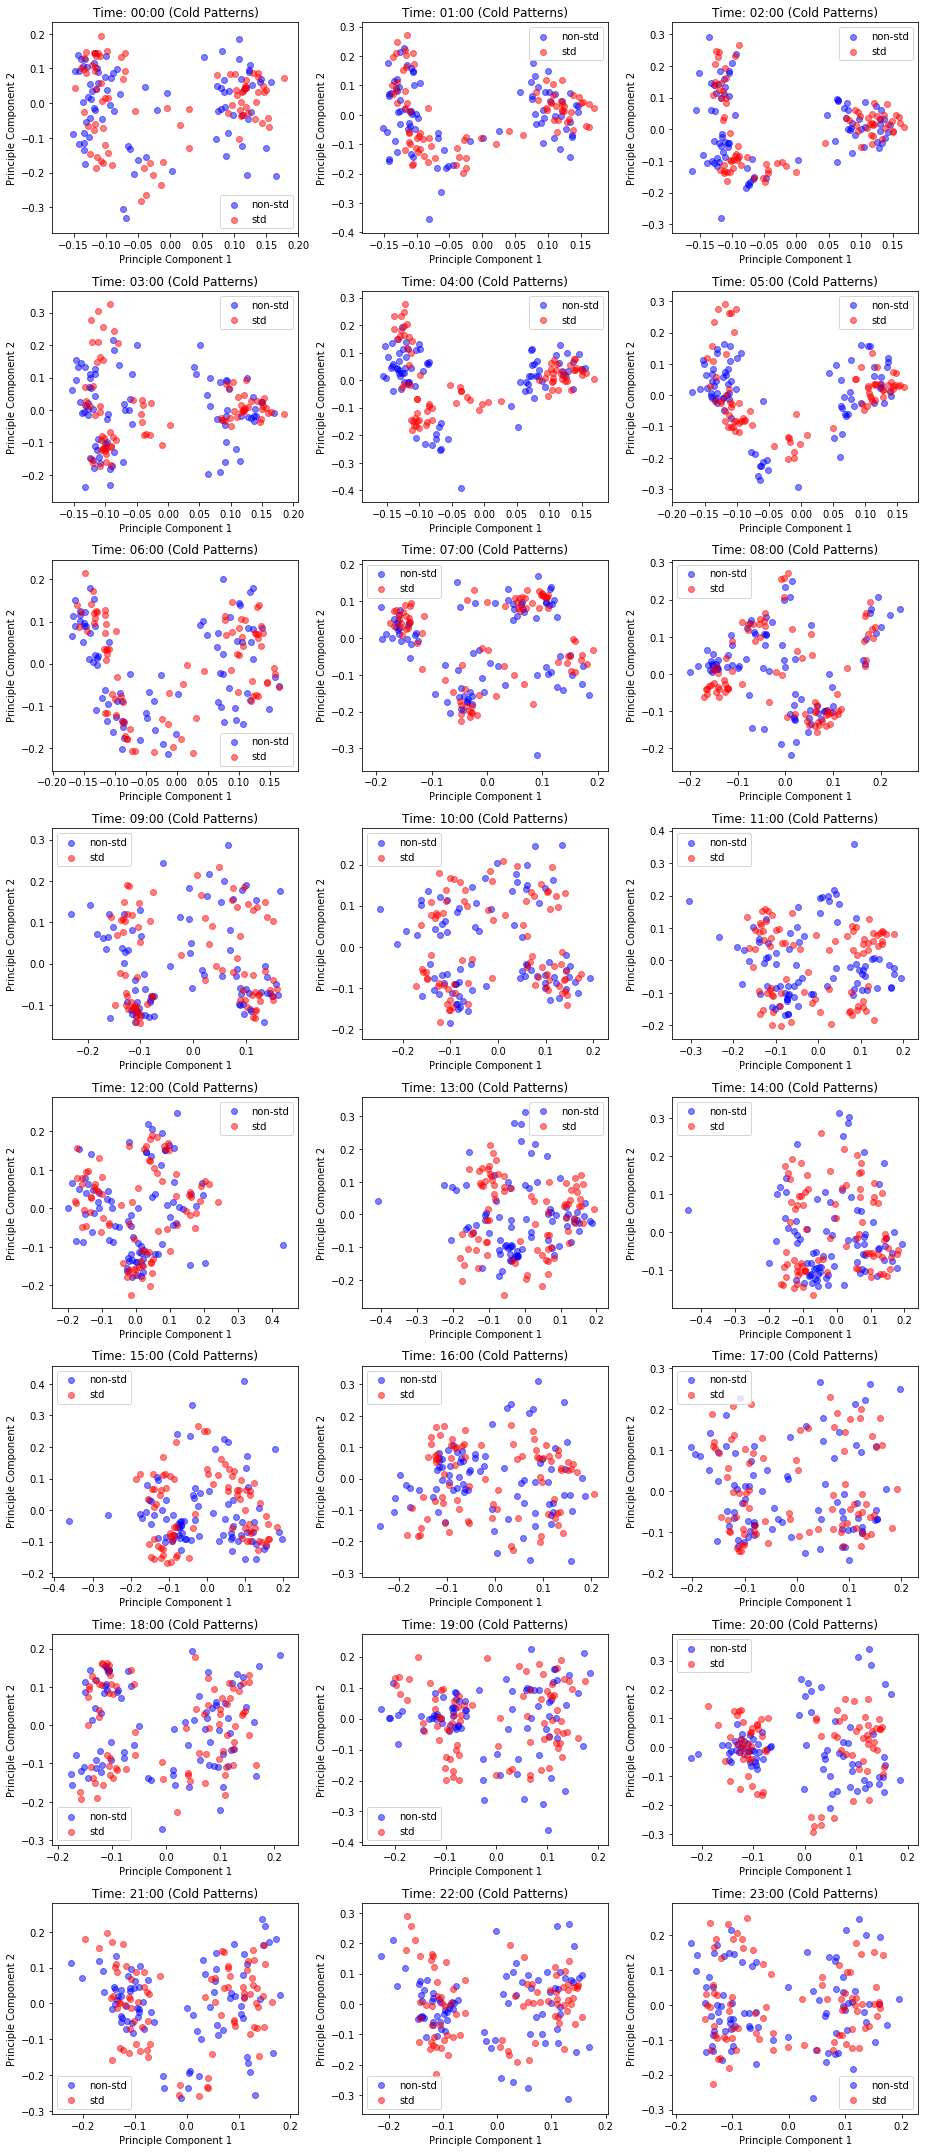

In [214]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[1], pca_nstd.components_[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(pca.components_[1], pca.components_[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[1], pca_nstd.components_[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(pca.components_[1], pca.components_[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
plt.tight_layout()

The above three types of plots show that std don't have significant advantage in this case, so we will use non-std in our later analysis.

Let's try to interprete PCs' meaning: 

(1) PC1 vs Temperature:

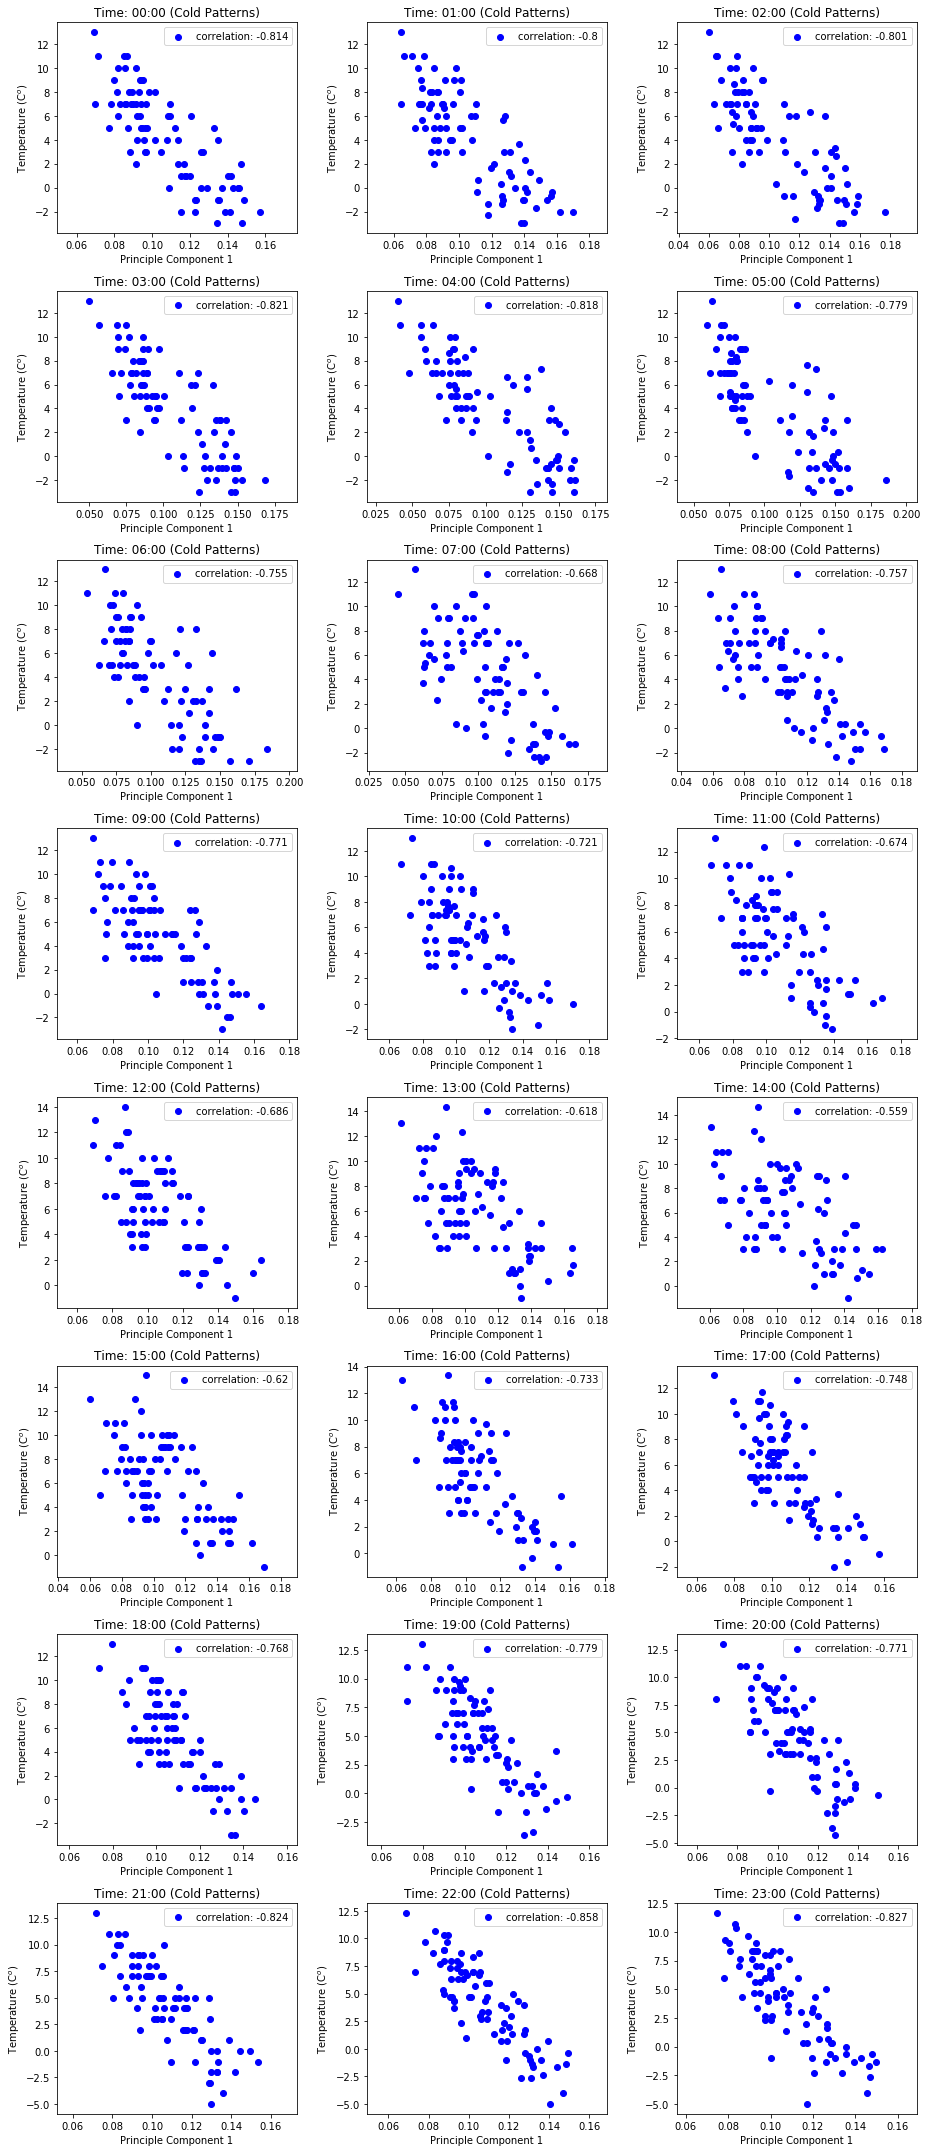

In [221]:
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[0], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')], c = 'blue', label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[0], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')])[0][1], 3)))
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel(r'Temperature (C$^o$)')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(pca_nstd.components_[0], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')], c = 'blue', label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[0], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')])[0][1], 3)))
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel(r'Temperature (C$^o$)')
plt.tight_layout()

2) PC2 vs 

In [218]:
df_wea1h_nf_cold[df_wea1h_nf_cold.GMT.str.contains('23:00:00')]

,GMT,TempC,TempF
23,2013-01-01 23:00:00,2.333333,36.333333
47,2013-01-02 23:00:00,8.333333,46.666667
71,2013-01-03 23:00:00,7.666667,46.333333
119,2013-01-05 23:00:00,7.000000,44.333333
143,2013-01-06 23:00:00,6.333333,44.333333
215,2013-01-09 23:00:00,2.666667,36.000000
287,2013-01-12 23:00:00,0.333333,32.666667
335,2013-01-14 23:00:00,-1.333333,29.333333
359,2013-01-15 23:00:00,-5.000000,22.666667
431,2013-01-18 23:00:00,-1.333333,30.000000


In [193]:
test2= pd.DataFrame(pd.to_datetime(test).dt.dayofweek)

In [114]:
test = df_wea1h_nf_cold['GMT'][df_wea1h_nf_cold.GMT.str.contains('23:00:00')]

In [177]:
test2

,GMT
23,1
47,1
71,1
119,1
143,1
215,1
287,1
335,1
359,1
431,1


In [187]:
np.corrcoef(pca_nstd.components_[3], test2.GMT)[0][1]

0.29330018349026094

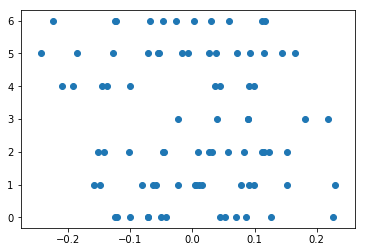

In [200]:
plt.scatter(pca_nstd.components_[6], test2)

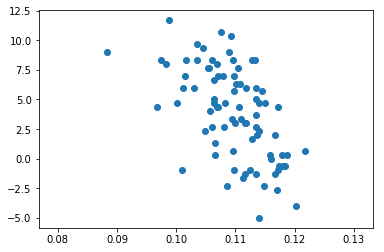

In [86]:
plt.scatter(pca.components_[0], df_wea1h_nf_cold.TempC[df_wea1h_nf_cold.GMT.str.contains('23:00:00')])

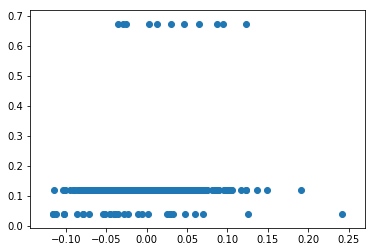

In [113]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.scatter(pca2.components_[11], df_tariff_1h.Price[df_tou1h.GMT.str.contains('09:00:00')])

In [101]:
df_tariff_1h

,GMT,Price,Event_tags
0,2013-01-01 00:00:00,0.1176,NaN
1,2013-01-01 01:00:00,0.1176,NaN
2,2013-01-01 02:00:00,0.1176,NaN
3,2013-01-01 03:00:00,0.1176,NaN
4,2013-01-01 04:00:00,0.1176,NaN
5,2013-01-01 05:00:00,0.1176,NaN
6,2013-01-01 06:00:00,0.1176,NaN
7,2013-01-01 07:00:00,0.1176,NaN
8,2013-01-01 08:00:00,0.1176,NaN
9,2013-01-01 09:00:00,0.1176,NaN


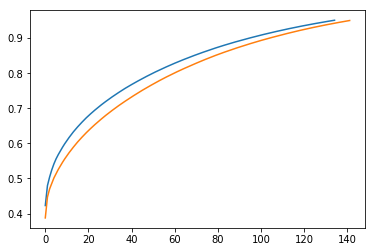

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Test with 9:00 am TOU data
y = df_tou1h_nf[df_tou1h_nf.GMT.str.contains('09:00:00')]
y.set_index('GMT', inplace = True)
y = y.transpose().dropna() # data for the specific hour, and filtering out null value
pca2 = PCA(0.95)
principleComponents2 = pca2.fit_transform(y)
principleDf2 = pd.DataFrame(data = principleComponents2)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [54]:
y = df_Ntou1h[df_Ntou1h.GMT.str.contains('09:00:00')]
y.set_index('GMT', inplace = True)
y = y.transpose()
y.dropna()

GMT,2013-01-01 09:00:00,2013-01-02 09:00:00,2013-01-03 09:00:00,2013-01-04 09:00:00,2013-01-05 09:00:00,2013-01-06 09:00:00,2013-01-07 09:00:00,2013-01-08 09:00:00,2013-01-09 09:00:00,2013-01-10 09:00:00,...,2013-12-22 09:00:00,2013-12-23 09:00:00,2013-12-24 09:00:00,2013-12-25 09:00:00,2013-12-26 09:00:00,2013-12-27 09:00:00,2013-12-28 09:00:00,2013-12-29 09:00:00,2013-12-30 09:00:00,2013-12-31 09:00:00
N0000,0.448,0.528,0.619,0.318,0.607,0.660,0.351,0.613,0.361,0.404,...,0.483,0.369,0.360,1.982,1.552,0.362,0.340,0.324,0.594,0.415
N0001,0.228,0.243,0.263,0.264,0.234,0.262,0.261,0.951,0.947,0.093,...,0.489,0.462,0.606,0.650,0.650,0.643,0.626,0.661,0.657,0.637
N0002,0.238,0.594,0.487,0.615,0.316,0.539,0.195,0.484,0.584,0.523,...,0.387,0.457,0.060,0.078,0.052,0.315,0.528,0.234,0.473,0.259
N0003,0.598,0.543,0.371,0.920,0.351,0.758,0.570,0.398,0.433,0.416,...,0.734,0.750,0.490,1.506,0.400,1.009,0.569,0.645,1.216,0.508
N0004,0.305,0.344,0.417,0.571,0.115,0.116,0.405,0.427,0.272,0.461,...,0.382,0.399,0.428,0.771,0.356,0.209,0.243,2.319,0.526,0.855
N0007,0.167,0.163,0.166,0.151,0.169,0.148,0.147,0.155,0.263,0.198,...,0.326,0.194,0.307,0.156,0.166,0.157,0.496,0.380,0.163,0.272
N0008,0.151,0.480,0.627,0.978,0.651,0.304,0.480,1.140,0.481,0.556,...,0.684,0.543,0.130,0.161,0.162,0.139,0.644,0.165,0.692,0.302
N0009,0.947,0.852,0.801,0.564,0.884,0.849,0.580,0.742,0.606,0.592,...,1.363,0.636,0.992,1.894,1.285,1.658,2.639,1.413,0.957,0.621
N0010,0.576,0.585,0.714,0.937,0.621,0.771,2.688,3.640,0.843,3.347,...,1.303,1.185,1.571,2.877,0.915,0.366,0.362,0.465,1.009,0.656
N0011,0.490,0.563,0.491,0.445,0.661,0.378,0.381,0.435,0.441,0.532,...,0.497,0.337,0.472,0.480,0.481,0.412,0.433,0.346,0.464,0.478
